## Model Training


#### Import Data and Required Packages

##### Importing Pandas, Numpy, Matplotlib, Seaborn, Scikit-Learn, and other required libraries


In [43]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

# Sklearn Import
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
)
from sklearn.svm import SVR

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# Other Import
import warnings

#### Import the CSV Data as Pandas DataFrame


In [44]:
# Read Data from CSV File and Store it in Pandas DataFrame Object
df = pd.read_csv("data/insurance.csv")

#### Show Top 5 Records


In [45]:
# Check the first 5 rows of the data
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Preparing X and Y variables


In [46]:
# Features except target variable (charges) are stored in X variable
X = df.drop(columns=["charges"], axis=1)

In [47]:
# Top 5 rows of X variable (features) are displayed below
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [48]:
# Categories in the different dataset variables
print("Categories in 'sex' variable:     ", end=" ")
print(df["sex"].unique())

print("Categories in 'smoker' variable:  ", end=" ")
print(df["smoker"].unique())

print("Categories in'region' variable:", end=" ")
print(df["region"].unique())

print("Categories in 'children' variable:     ", end=" ")
print(df["children"].unique())

Categories in 'sex' variable:      ['female' 'male']
Categories in 'smoker' variable:   ['yes' 'no']
Categories in'region' variable: ['southwest' 'southeast' 'northwest' 'northeast']
Categories in 'children' variable:      [0 1 3 2 5 4]


In [49]:
# Target variable (charges) is stored in y variable
y = df["charges"]

In [50]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [51]:
# define categorical columns
categorical_features = [feature for feature in X.columns if X[feature].dtype == "O"]

# print columns
print(
    f"We have {len(categorical_features)} categorical features : {categorical_features}"
)

We have 3 categorical features : ['sex', 'smoker', 'region']


In [52]:
# define numerical features
numeric_features = [feature for feature in X.columns if X[feature].dtype != "O"]

# print columns
print(f"We have {len(numeric_features)} numerical features : {numeric_features}")

We have 3 numerical features : ['age', 'bmi', 'children']


In [53]:
# Discrete numerical features
discrete_feature = [
    feature for feature in numeric_features if len(X[feature].unique()) < 25
]
print(f"We have {len(discrete_feature)} discrete features : {discrete_feature}")

We have 1 discrete features : ['children']


In [54]:
# Contunious numerical features
continuous_feature = [
    feature for feature in numeric_features if feature not in discrete_feature
]
print(f"We have {len(continuous_feature)} continuous features : {continuous_feature}")

We have 2 continuous features : ['age', 'bmi']


In [55]:
# Discrete numerical features are converted to object type for encoding purpose later on in the pipeline
X[discrete_feature] = X[discrete_feature].astype("O")

In [56]:
# StandardScaler and OrdinalEncoder used for numerical and categorical features respectively
numeric_transformer = StandardScaler()
or_transformer = OrdinalEncoder()

# Create Column Transformer for Preprocessing the Data in Pipeline
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", or_transformer, categorical_features + discrete_feature),
        ("StandardScaler", numeric_transformer, continuous_feature),
    ]
)

In [57]:
# Preprocess the data
X = preprocessor.fit_transform(X)

In [58]:
# Check the shape of X
X.shape

(1338, 6)

In [59]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split

# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# check the shape of X_train and X_test
X_train.shape, X_test.shape

((1070, 6), (268, 6))

#### Create an Evaluate Function to give all metrics after model Training


In [60]:
def evaluate_model(true, predicted):
    """
    Evaluate the performance of a regression model.

    Parameters:
    true (array-like): The true values.
    predicted (array-like): The predicted values.

    Returns:
    tuple: A tuple containing the mean absolute error (MAE), root mean squared error (RMSE),
        and R-squared (R2) score.

    """
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [61]:
# Models to be used for training
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "Bayesian Ridge": BayesianRidge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "SVR": SVR(),
}

# Train and Evaluate the models
model_list = []
r2_list = []

# Iterate through each model and train and evaluate the model
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)  # Train model


    # Make predictions on train and test dataset using the trained model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # Evaluate Train and Test dataset predictions
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(
        y_train, y_train_pred
    )


    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])


    print("Model performance for Training set")


    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print("----------------------------------")


    print("Model performance for Test set")


    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)


    print("=" * 35)
    print("\n")

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 6105.7893
- Mean Absolute Error: 4208.7620
- R2 Score: 0.7417
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5799.5871
- Mean Absolute Error: 4186.5089
- R2 Score: 0.7833


Lasso
Model performance for Training set
- Root Mean Squared Error: 6105.7905
- Mean Absolute Error: 4208.9390
- R2 Score: 0.7417
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5799.9337
- Mean Absolute Error: 4187.0095
- R2 Score: 0.7833


Ridge
Model performance for Training set
- Root Mean Squared Error: 6106.0360
- Mean Absolute Error: 4218.0230
- R2 Score: 0.7417
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5803.0785
- Mean Absolute Error: 4197.6978
- R2 Score: 0.7831


ElasticNet
Model performance for Training set
- Root Mean Squared Error: 9528.9607
- Mean Absolute Error: 7257.4490
- R2 Score:

### Results


In [62]:
# Create a dataframe to compare the performance of each model
pd.DataFrame(
    list(zip(model_list, r2_list)), columns=["Model Name", "R2_Score"]
).sort_values(by=["R2_Score"], ascending=False)

,Model Name,R2_Score
11,Gradient Boosting Regressor,0.877571
9,CatBoosting Regressor,0.870931
7,Random Forest Regressor,0.866352
8,XGBRegressor,0.851119
10,AdaBoost Regressor,0.835333
0,Linear Regression,0.783346
1,Lasso,0.783320
4,Bayesian Ridge,0.783248
2,Ridge,0.783085
6,Decision Tree,0.730012


## Linear Regression


In [63]:
# lin_model = LinearRegression(fit_intercept=True)
# lin_model = lin_model.fit(X_train, y_train)
# y_pred = lin_model.predict(X_test)
# score = r2_score(y_test, y_pred) * 100
# print(" Accuracy of the model is %.2f" % score)

In [64]:
catboost_model = CatBoostRegressor(verbose=False)
catboost_model = catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
score = r2_score(y_test, y_pred) * 100
print(" Accuracy of the model is %.2f" % score)

 Accuracy of the model is 87.09


## Plot y_pred and y_test


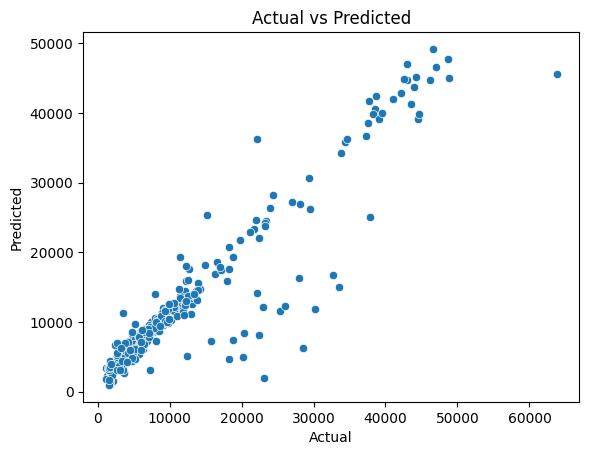

In [65]:
# Plot the Actual vs Predicted values as a scatterplot
sns.scatterplot(x=y_test, y=y_pred)


plt.xlabel("Actual")


plt.ylabel("Predicted")


plt.title("Actual vs Predicted")


plt.show()

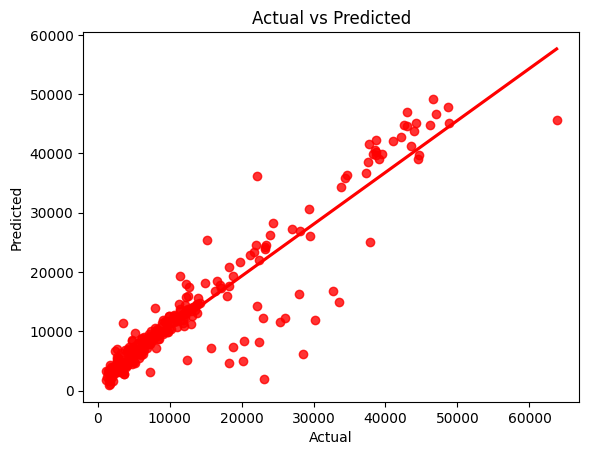

In [66]:
# Plot the Actual vs Predicted values as a regression plot
sns.regplot(x=y_test, y=y_pred, ci=None, color="red")

plt.xlabel("Actual")

plt.ylabel("Predicted")

plt.title("Actual vs Predicted")

plt.show()

#### Difference between Actual and Predicted Values


In [67]:
# Dataframe to compare the Actual and Predicted values
pred_df = pd.DataFrame(

    {"Actual Value": y_test, "Predicted Value": y_pred, "Difference": y_test - y_pred}
)
# Display the dataframe
pred_df

,Actual Value,Predicted Value,Difference
764,9095.06825,11952.455940,-2857.387690
887,5272.17580,6928.488601,-1656.312801
890,29330.98315,30604.889148,-1273.905998
1293,9301.89355,10180.356292,-878.462742
259,33750.29180,34269.632168,-519.340368
...,...,...,...
109,47055.53210,46592.616056,462.916044
575,12222.89830,13066.593410,-843.695110
535,6067.12675,6003.703686,63.423064
543,63770.42801,45613.698602,18156.729408
